## Imports and Setup

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from lightgbm import LGBMRegressor
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split



from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import StackingRegressor

import matplotlib.pyplot as plt

from scipy import stats
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
import pickle
import json


import warnings
warnings.filterwarnings("ignore")

In [49]:
preprocessed_dataset = pd.read_csv("../data/pre-processed/preprocessed_youtube_data.csv")

In [50]:
# Convert to datetime if not already
preprocessed_dataset['published_time'] = pd.to_datetime(preprocessed_dataset['published_time'], format='%H:%M:%S', errors='coerce')

# Extract hour and minute
preprocessed_dataset['published_hour'] = preprocessed_dataset['published_time'].dt.hour
preprocessed_dataset['published_minute'] = preprocessed_dataset['published_time'].dt.minute

# Drop the original time column
preprocessed_dataset.drop(columns=['published_time'], inplace=True)

In [51]:
# Separate label encoders for each column
le_day = LabelEncoder()
le_def = LabelEncoder()

preprocessed_dataset['published_day_of_week'] = le_day.fit_transform(preprocessed_dataset['published_day_of_week'])
preprocessed_dataset['definition'] = le_def.fit_transform(preprocessed_dataset['definition'])


In [52]:
missing_mask = preprocessed_dataset[['like_count_initial', 'like_count_final', 'view_count_initial', 'view_count_final']].isnull()

# Check rows where all four columns are NaN
rows_all_nan = missing_mask.all(axis=1)

print("Number of rows with all four columns NaN:", rows_all_nan.sum())

# Optionally, see those rows
print(preprocessed_dataset[rows_all_nan])

Number of rows with all four columns NaN: 5
       category_id country  definition logged_at_initial  view_count_initial  \
4465           NaN     NaN           2               NaN                 NaN   
8504           NaN     NaN           2               NaN                 NaN   
17296          NaN     NaN           2               NaN                 NaN   
18396          NaN     NaN           2               NaN                 NaN   
22842          NaN     NaN           2               NaN                 NaN   

       like_count_initial  c_view_count_initial logged_at_final  \
4465                  NaN                   NaN             NaN   
8504                  NaN                   NaN             NaN   
17296                 NaN                   NaN             NaN   
18396                 NaN                   NaN             NaN   
22842                 NaN                   NaN             NaN   

       view_count_final  like_count_final  ...  channel_avg_views  \
446

In [53]:
rows_any_nan = missing_mask.any(axis=1)
print("Rows with any of the four columns NaN:", rows_any_nan.sum())

Rows with any of the four columns NaN: 705


In [54]:
preprocessed_dataset.columns

Index(['category_id', 'country', 'definition', 'logged_at_initial',
       'view_count_initial', 'like_count_initial', 'c_view_count_initial',
       'logged_at_final', 'view_count_final', 'like_count_final',
       'published_year', 'published_month', 'published_day_of_week',
       'avg_view_diff_per_category', 'avg_likes_diff_per_category',
       'channel_avg_views', 'channel_growth_potential',
       'channel_virality_score', 'log_channel_subs',
       'relative_views_to_category', 'relative_likes_to_category',
       'logged_at_initial_hour', 'logged_at_final_hour', 'published_hour',
       'published_minute'],
      dtype='object')

In [56]:
# Step 1: Convert to category
preprocessed_dataset['country'] = preprocessed_dataset['country'].astype('category')

# Step 2: Save mapping BEFORE encoding
categories = list(preprocessed_dataset['country'].cat.categories)
country_to_code = {country: idx for idx, country in enumerate(categories)}

with open("country_encoding.json", "w") as f:
    json.dump(country_to_code, f)

# Step 3: Encode with .cat.codes
preprocessed_dataset['country_encoded'] = preprocessed_dataset['country'].cat.codes


preprocessed_dataset['category_id'] = (
    preprocessed_dataset['category_id']
    .fillna(-1)  # or any placeholder like 999
    .astype(int)
)


In [57]:
preprocessed_dataset.drop(columns=['logged_at_final', 'logged_at_initial','country'], inplace=True)

In [58]:
preprocessed_dataset.dtypes

category_id                      int64
definition                       int64
view_count_initial             float64
like_count_initial             float64
c_view_count_initial           float64
view_count_final               float64
like_count_final               float64
published_year                   int64
published_month                  int64
published_day_of_week            int64
avg_view_diff_per_category     float64
avg_likes_diff_per_category    float64
channel_avg_views              float64
channel_growth_potential       float64
channel_virality_score         float64
log_channel_subs               float64
relative_views_to_category     float64
relative_likes_to_category     float64
logged_at_initial_hour         float64
logged_at_final_hour           float64
published_hour                   int32
published_minute                 int32
country_encoded                   int8
dtype: object

In [59]:
preprocessed_dataset = preprocessed_dataset.dropna(subset=[
    'like_count_initial',
    'like_count_final',
    'view_count_initial',
    'view_count_final'
])

# Define target columns
target_columns = [
    'like_count_initial',
    'like_count_final',
    'view_count_initial',
    'view_count_final'
]

In [60]:
# Choose columns to check for outliers, e.g. target columns
cols_to_check = target_columns  # or other numeric features

z_scores = np.abs(stats.zscore(preprocessed_dataset[cols_to_check]))
# Define threshold, e.g. 3 std deviations
threshold = 3
# Keep only rows where all z-scores are below threshold (no outlier)
non_outliers = (z_scores < threshold).all(axis=1)


print(f"Rows before outlier removal: {len(preprocessed_dataset)}")
preprocessed_dataset = preprocessed_dataset[non_outliers]
print(f"Rows after outlier removal: {len(preprocessed_dataset)}")

Rows before outlier removal: 24643
Rows after outlier removal: 24406


In [61]:
# Separate features and targets
X = preprocessed_dataset.drop(columns=target_columns)
y = preprocessed_dataset[target_columns]


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 4000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 14),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'objective': 'reg:squarederror',
        # Remove GPU parameters
        # 'tree_method': 'gpu_hist',
        # 'predictor': 'gpu_predictor',
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = xgb.XGBRegressor(**params)
    try:
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )
    except TypeError:
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='mape',
            verbose=False
        )
    
    preds = model.predict(X_valid)
    mape = mean_absolute_percentage_error(y_valid, preds)
    return mape

# Run XGBoost optimization
xgb_study = optuna.create_study(direction="minimize", study_name="XGBoost_Optimization")
xgb_study.optimize(xgb_objective, n_trials=100)

print("=== XGBoost Results ===")
print("Best parameters:", xgb_study.best_trial.params)
print("Best MAPE:", xgb_study.best_value)


[I 2025-08-03 18:20:27,498] A new study created in memory with name: XGBoost_Optimization
[I 2025-08-03 18:21:09,858] Trial 0 finished with value: 8.224151984249242e+16 and parameters: {'n_estimators': 3787, 'learning_rate': 0.19634949018837544, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.7866741031319747, 'colsample_bytree': 0.6643097331181507, 'gamma': 0.9469537508045661, 'reg_alpha': 0.29955528496479455, 'reg_lambda': 0.6030332210100074}. Best is trial 0 with value: 8.224151984249242e+16.
[I 2025-08-03 18:21:24,278] Trial 1 finished with value: 9.542191548045722e+16 and parameters: {'n_estimators': 3001, 'learning_rate': 0.051736447929231405, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.6897238569421463, 'colsample_bytree': 0.6779052724638904, 'gamma': 0.16540004823703147, 'reg_alpha': 0.26670541971309625, 'reg_lambda': 0.27300948157281946}. Best is trial 0 with value: 8.224151984249242e+16.
[I 2025-08-03 18:21:58,120] Trial 2 finished with value: 8.29041044472463

=== XGBoost Results ===
Best parameters: {'n_estimators': 2391, 'learning_rate': 0.012683411925374116, 'max_depth': 14, 'min_child_weight': 5, 'subsample': 0.8652870625860062, 'colsample_bytree': 0.7746289769529869, 'gamma': 0.6247270454070633, 'reg_alpha': 0.0013716861663053345, 'reg_lambda': 0.002577945152576838}
Best MAPE: 6.941727148264653e+16


In [51]:
y.shape

(20399, 4)

In [52]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor  # Missing import
from sklearn.metrics import mean_absolute_percentage_error

def lgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 4000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 14),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        # Remove 'device': 'gpu' to avoid potential issues
        'objective': 'regression',
        'metric': 'mape',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1  # Suppress LightGBM output
    }
    
    base_model = LGBMRegressor(**params)
    model = MultiOutputRegressor(base_model)
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_valid)
    mape = mean_absolute_percentage_error(y_valid, preds)
    return mape

# Run LightGBM optimization
lgb_study = optuna.create_study(direction="minimize", study_name="LightGBM_Optimization")
lgb_study.optimize(lgb_objective, n_trials=100)

print("=== LightGBM Results ===")
print("Best parameters:", lgb_study.best_trial.params)
print("Best MAPE:", lgb_study.best_value)


[I 2025-08-02 21:40:50,600] A new study created in memory with name: LightGBM_Optimization
[I 2025-08-02 21:41:37,610] Trial 0 finished with value: 6.5382478689029224e+16 and parameters: {'n_estimators': 2822, 'learning_rate': 0.08570425375424456, 'max_depth': 9, 'reg_alpha': 0.5335231369570369, 'reg_lambda': 0.6203681127136559, 'min_child_samples': 46, 'colsample_bytree': 0.9039438874152697, 'subsample': 0.8172462847932178}. Best is trial 0 with value: 6.5382478689029224e+16.
[I 2025-08-02 21:41:52,926] Trial 1 finished with value: 5.955079553190746e+16 and parameters: {'n_estimators': 794, 'learning_rate': 0.1804379168767179, 'max_depth': 13, 'reg_alpha': 0.8168173780800553, 'reg_lambda': 0.6129455538400196, 'min_child_samples': 28, 'colsample_bytree': 0.8932614861199071, 'subsample': 0.6234262213031547}. Best is trial 1 with value: 5.955079553190746e+16.
[I 2025-08-02 21:42:19,143] Trial 2 finished with value: 6.712411304077934e+16 and parameters: {'n_estimators': 1842, 'learning_ra

=== LightGBM Results ===
Best parameters: {'n_estimators': 943, 'learning_rate': 0.07464963936479606, 'max_depth': 13, 'reg_alpha': 0.616009709809939, 'reg_lambda': 0.2547406136417159, 'min_child_samples': 11, 'colsample_bytree': 0.9855233731426458, 'subsample': 0.767216632425857}
Best MAPE: 4.843485347968647e+16


In [53]:
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

def catboost_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 4000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 4, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 64),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0, 1.0),
        'loss_function': 'MAPE',
        'eval_metric': 'MAPE',
        'random_state': 42,
        # Remove 'task_type': 'GPU' - this is causing the error
        'verbose': False
    }
    
    # For multi-output regression with CatBoost
    base_model = CatBoostRegressor(**params)
    model = MultiOutputRegressor(base_model)
    
    # MultiOutputRegressor doesn't support eval_set and early_stopping_rounds
    model.fit(X_train, y_train)
    
    preds = model.predict(X_valid)
    mape = mean_absolute_percentage_error(y_valid, preds)
    return mape

# Run CatBoost optimization
catboost_study = optuna.create_study(direction="minimize", study_name="CatBoost_Optimization")
catboost_study.optimize(catboost_objective, n_trials=100)

print("=== CatBoost Results ===")
print("Best parameters:", catboost_study.best_trial.params)
print("Best MAPE:", catboost_study.best_value)


[I 2025-08-02 22:13:38,677] A new study created in memory with name: CatBoost_Optimization
[I 2025-08-02 22:13:58,403] Trial 0 finished with value: 7094171360654952.0 and parameters: {'n_estimators': 2354, 'learning_rate': 0.13866782646818265, 'depth': 7, 'min_data_in_leaf': 57, 'l2_leaf_reg': 1.5940930152446202, 'bagging_temperature': 0.48768378024656867, 'random_strength': 0.6037329796310219}. Best is trial 0 with value: 7094171360654952.0.
[I 2025-08-02 22:14:06,104] Trial 1 finished with value: 3798934140177269.5 and parameters: {'n_estimators': 1010, 'learning_rate': 0.17823385119095336, 'depth': 6, 'min_data_in_leaf': 33, 'l2_leaf_reg': 7.506472734926184, 'bagging_temperature': 0.4021988574565867, 'random_strength': 0.060173661108357535}. Best is trial 1 with value: 3798934140177269.5.
[I 2025-08-02 22:14:28,033] Trial 2 finished with value: 817173551564478.5 and parameters: {'n_estimators': 3287, 'learning_rate': 0.13691391969133332, 'depth': 5, 'min_data_in_leaf': 33, 'l2_leaf_

=== CatBoost Results ===
Best parameters: {'n_estimators': 1816, 'learning_rate': 0.01293573801177398, 'depth': 4, 'min_data_in_leaf': 28, 'l2_leaf_reg': 3.8871680455683126, 'bagging_temperature': 0.16101400624123763, 'random_strength': 0.1518675050298522}
Best MAPE: 186854823656817.9


In [54]:
results = {
    'XGBoost': xgb_study.best_value,
    'LightGBM': lgb_study.best_value,
    'CatBoost': catboost_study.best_value
}

print("\n=== Final Comparison ===")
for model_name, best_mape in results.items():
    print(f"{model_name}: {best_mape:.6f}")

best_model = min(results, key=results.get)
print(f"\nBest performing model: {best_model} with MAPE: {results[best_model]:.6f}")


=== Final Comparison ===
XGBoost: 37693285824724992.000000
LightGBM: 48434853479686472.000000
CatBoost: 186854823656817.906250

Best performing model: CatBoost with MAPE: 186854823656817.906250


In [55]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_valid.shape, y_valid.shape)
print("Any NaN values in targets:", y_train.isnull().sum().sum())


Training set shape: (16319, 17) (16319, 4)
Validation set shape: (4080, 17) (4080, 4)
Any NaN values in targets: 0


In [56]:
xgb_model = xgb.XGBRegressor(**xgb_study.best_trial.params)
                             

In [57]:
lgbm_model = LGBMRegressor(**lgb_study.best_trial.params)


In [58]:
catboost_model = CatBoostRegressor(**catboost_study.best_trial.params)

In [59]:
xgb_model2 = MultiOutputRegressor(xgb_model)
xgb_model2.fit(X_train, y_train)
preds =xgb_model2.predict(X_valid)
overall_mae = mean_absolute_error(y_valid, preds)
print("Overall MAE:", overall_mae)

print("\nMAE for each output column:")
for col_idx in range(y_valid.shape[1]):
    col_mae = mean_absolute_error(y_valid.iloc[:, col_idx], preds[:, col_idx])
    print(f"Column {col_idx}: {col_mae:.4f}")

# Manual MAPE calculation to debug
# manual_mape = np.mean(np.abs((y_valid - preds) / y_valid)) * 100
# print("Manual MAPE:", manual_mape)


Overall MAE: 321.56524658203125

MAE for each output column:
Column 0: 20.4776
Column 1: 21.4303
Column 2: 602.1902
Column 3: 642.1630


In [60]:
lgbm_model2 = MultiOutputRegressor(lgbm_model)
lgbm_model2.fit(X_train, y_train)
preds =lgbm_model2.predict(X_valid)
overall_mae = mean_absolute_error(y_valid, preds)
print("Overall MAE:", overall_mae)

print("\nMAE for each output column:")
for col_idx in range(y_valid.shape[1]):
    col_mae = mean_absolute_error(y_valid.iloc[:, col_idx], preds[:, col_idx])
    print(f"Column {col_idx}: {col_mae:.4f}")

Overall MAE: 347.3586199580161

MAE for each output column:
Column 0: 21.7041
Column 1: 21.6993
Column 2: 651.2420
Column 3: 694.7891


In [61]:
catboost_model2 = MultiOutputRegressor(catboost_model)
catboost_model2.fit(X_train, y_train)
preds =catboost_model2.predict(X_valid)
overall_mae = mean_absolute_error(y_valid, preds)
print("Overall MAE:", overall_mae)

print("\nMAE for each output column:")
for col_idx in range(y_valid.shape[1]):
    col_mae = mean_absolute_error(y_valid.iloc[:, col_idx], preds[:, col_idx])
    print(f"Column {col_idx}: {col_mae:.4f}")

0:	learn: 146.9778915	total: 2.01ms	remaining: 3.65s
1:	learn: 146.2945288	total: 3.39ms	remaining: 3.07s
2:	learn: 145.6282716	total: 4.26ms	remaining: 2.58s
3:	learn: 144.9644136	total: 5.47ms	remaining: 2.48s
4:	learn: 144.3102594	total: 6.55ms	remaining: 2.37s
5:	learn: 143.6659232	total: 7.49ms	remaining: 2.26s
6:	learn: 143.0610635	total: 8.27ms	remaining: 2.14s
7:	learn: 142.4473023	total: 9.21ms	remaining: 2.08s
8:	learn: 141.8195197	total: 11.1ms	remaining: 2.22s
9:	learn: 141.2183728	total: 12.1ms	remaining: 2.19s
10:	learn: 140.6320634	total: 12.9ms	remaining: 2.12s
11:	learn: 140.0472900	total: 13.9ms	remaining: 2.08s
12:	learn: 139.4821887	total: 14.7ms	remaining: 2.03s
13:	learn: 138.9280429	total: 15.5ms	remaining: 2s
14:	learn: 138.3738195	total: 17.2ms	remaining: 2.06s
15:	learn: 137.8303391	total: 18.1ms	remaining: 2.03s
16:	learn: 137.2957119	total: 19.2ms	remaining: 2.04s
17:	learn: 136.7694660	total: 20.2ms	remaining: 2.01s
18:	learn: 136.2561922	total: 21.1ms	rema

In [62]:
meta_model = LinearRegression()

In [63]:
stacking_model2 = StackingRegressor(
    estimators=[
        ('xgb', xgb_model), 
        ('lgb', lgbm_model), 
        ('catboost', catboost_model)
    ],
    final_estimator=meta_model,
    n_jobs=-1

)
stacking_model2 = MultiOutputRegressor(stacking_model2)
# stacking_model2.fit(X_scaled, y)

In [64]:
stacking_model2.fit(X_train, y_train)
preds =stacking_model2.predict(X_valid)
overall_mae = mean_absolute_error(y_valid, preds)
print("Overall MAE:", overall_mae)

print("\nMAE for each output column:")
for col_idx in range(y_valid.shape[1]):
    col_mae = mean_absolute_error(y_valid.iloc[:, col_idx], preds[:, col_idx])
    print(f"Column {col_idx}: {col_mae:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1721
[LightGBM] [Info] Number of data points in the train set: 16319, number of used features: 15
[LightGBM] [Info] Start training from score 33.251241
0:	learn: 146.9778915	total: 59ms	remaining: 1m 47s
1:	learn: 146.2945288	total: 61.7ms	remaining: 56s
2:	learn: 145.6282716	total: 64ms	remaining: 38.7s
3:	learn: 144.9644136	total: 66.6ms	remaining: 30.2s
4:	learn: 144.3102594	total: 69.5ms	remaining: 25.2s
5:	learn: 143.6659232	total: 71.5ms	remaining: 21.6s
6:	learn: 143.0610635	total: 74.4ms	remaining: 19.2s
7:	learn: 142.4473023	total: 76.6ms	remaining: 17.3s
8:	learn: 141.8195197	total: 78.5ms	remaining: 15.8s
9:	learn: 141.2183728	total: 81.1ms	remaining: 14.6s
10:	learn: 140.6320634	total: 86.2ms	remaining: 14.1s
11:	learn: 140

In [65]:
# 1. Create a blend split from training data
X_base, X_blend, y_base, y_blend = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2. Wrap models in MultiOutputRegressor
xgb_model_blend = MultiOutputRegressor(xgb_model)
lgbm_model_blend = MultiOutputRegressor(lgbm_model)
catboost_model_blend = MultiOutputRegressor(catboost_model)

# 3. Train base models on base set
xgb_model_blend.fit(X_base, y_base)
lgbm_model_blend.fit(X_base, y_base)
catboost_model_blend.fit(X_base, y_base)

0:	learn: 146.9778915	total: 2.26ms	remaining: 4.1s
1:	learn: 146.2945288	total: 3.14ms	remaining: 2.85s
2:	learn: 145.6282716	total: 3.93ms	remaining: 2.38s
3:	learn: 144.9644136	total: 4.7ms	remaining: 2.13s
4:	learn: 144.3102594	total: 5.54ms	remaining: 2.01s
5:	learn: 143.6659232	total: 6.34ms	remaining: 1.91s
6:	learn: 143.0610635	total: 7.1ms	remaining: 1.83s
7:	learn: 142.4473023	total: 7.88ms	remaining: 1.78s
8:	learn: 141.8195197	total: 8.65ms	remaining: 1.74s
9:	learn: 141.2183728	total: 9.48ms	remaining: 1.71s
10:	learn: 140.6320634	total: 10.2ms	remaining: 1.68s
11:	learn: 140.0472900	total: 11.1ms	remaining: 1.66s
12:	learn: 139.4821887	total: 11.9ms	remaining: 1.65s
13:	learn: 138.9280429	total: 13ms	remaining: 1.67s
14:	learn: 138.3738195	total: 13.8ms	remaining: 1.65s
15:	learn: 137.8303391	total: 14.5ms	remaining: 1.63s
16:	learn: 137.2957119	total: 15.4ms	remaining: 1.63s
17:	learn: 136.7694660	total: 16.2ms	remaining: 1.61s
18:	learn: 136.2561922	total: 17ms	remainin

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x30d981010>)

In [66]:
# 4. Predict on blend set to create meta features
xgb_preds_blend = xgb_model_blend.predict(X_blend)
lgbm_preds_blend = lgbm_model_blend.predict(X_blend)
catboost_preds_blend = catboost_model_blend.predict(X_blend)

# 5. Stack base model predictions horizontally for meta input
X_meta_blend = np.hstack([xgb_preds_blend, lgbm_preds_blend, catboost_preds_blend])

# 6. Train meta-model on blend predictions
meta_model_blend = MultiOutputRegressor(LinearRegression())
meta_model_blend.fit(X_meta_blend, y_blend)

# 7. Predict on validation set using base models
xgb_preds_valid = xgb_model_blend.predict(X_valid)
lgbm_preds_valid = lgbm_model_blend.predict(X_valid)
catboost_preds_valid = catboost_model_blend.predict(X_valid)




In [67]:
# 8. Stack base predictions for final meta input
X_meta_valid = np.hstack([xgb_preds_valid, lgbm_preds_valid, catboost_preds_valid])

# 9. Final prediction from meta-model
final_preds = meta_model_blend.predict(X_meta_valid)

# 10. Evaluate
overall_mae = mean_absolute_error(y_valid, final_preds)
print("🔁 Blending - Overall MAE:", overall_mae)

print("\nMAE for each output column:")
for col_idx in range(y_valid.shape[1]):
    col_mae = mean_absolute_error(y_valid.iloc[:, col_idx], final_preds[:, col_idx])
    print(f"Column {col_idx}: {col_mae:.4f}")

🔁 Blending - Overall MAE: 297.91953366750204

MAE for each output column:
Column 0: 20.5757
Column 1: 21.2984
Column 2: 558.1412
Column 3: 591.6629


In [68]:
# Store MAEs for each model
model_maes = {
    "XGBoost": [mean_absolute_error(y_valid.iloc[:, i], xgb_model2.predict(X_valid)[:, i]) for i in range(y.shape[1])],
    "LightGBM": [mean_absolute_error(y_valid.iloc[:, i], lgbm_model2.predict(X_valid)[:, i]) for i in range(y.shape[1])],
    "CatBoost": [mean_absolute_error(y_valid.iloc[:, i], catboost_model2.predict(X_valid)[:, i]) for i in range(y.shape[1])],
    "Stacking": [mean_absolute_error(y_valid.iloc[:, i], stacking_model2.predict(X_valid)[:, i]) for i in range(y.shape[1])],
    "Blending": [mean_absolute_error(y_valid.iloc[:, i], final_preds[:, i]) for i in range(y.shape[1])]
}

target_names = y.columns.tolist()


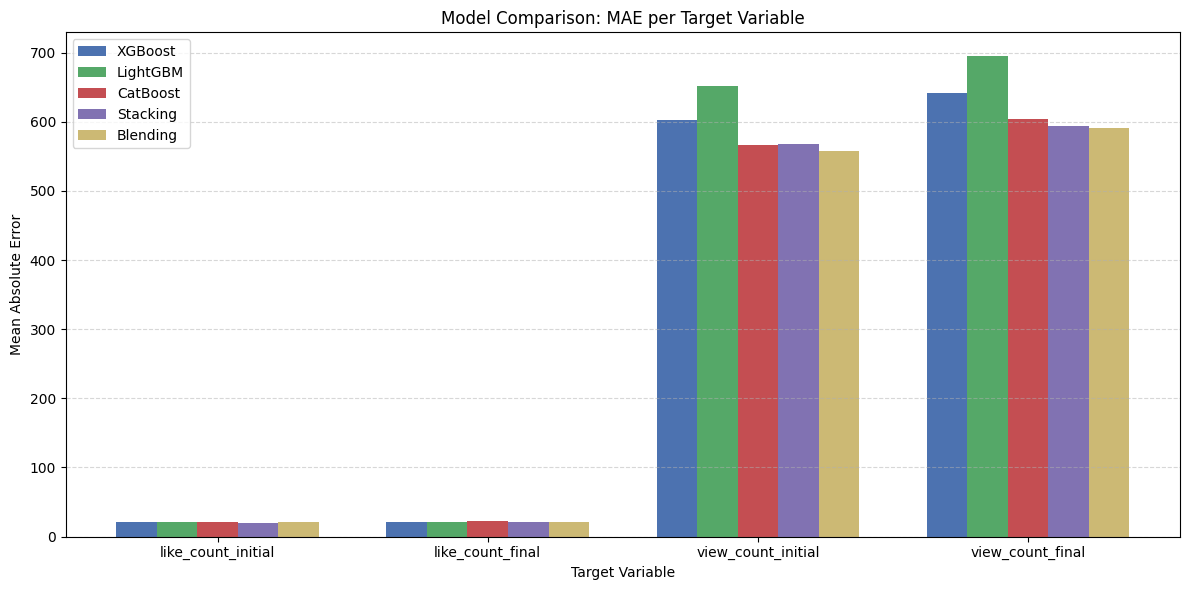

In [69]:
# Setup
bar_width = 0.15
index = np.arange(len(target_names))

# Plot
plt.figure(figsize=(12, 6))

colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']
for i, (model_name, mae_list) in enumerate(model_maes.items()):
    plt.bar(index + i * bar_width, mae_list, bar_width, label=model_name, color=colors[i])

# Labels & ticks
plt.xlabel('Target Variable')
plt.ylabel('Mean Absolute Error')
plt.title('Model Comparison: MAE per Target Variable')
plt.xticks(index + bar_width * 2, target_names)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

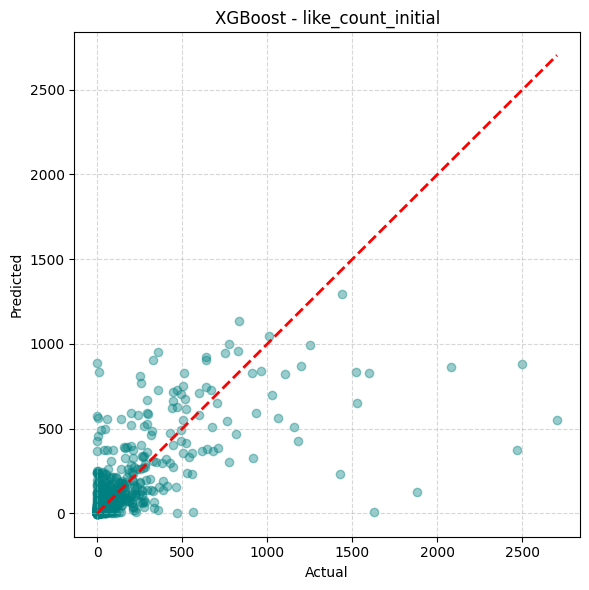

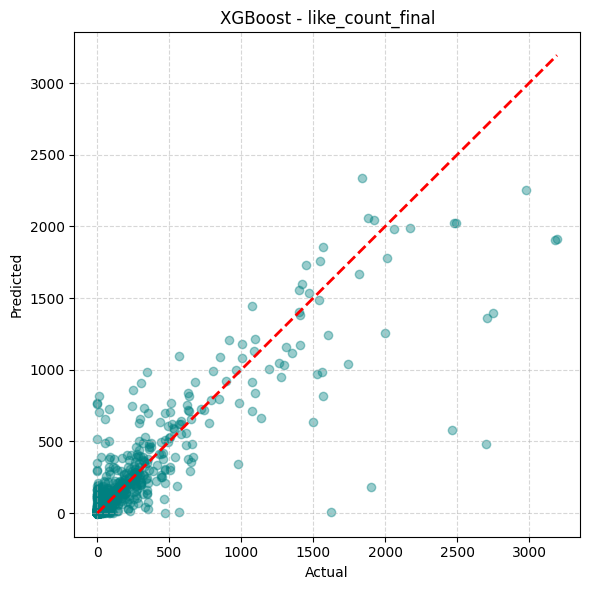

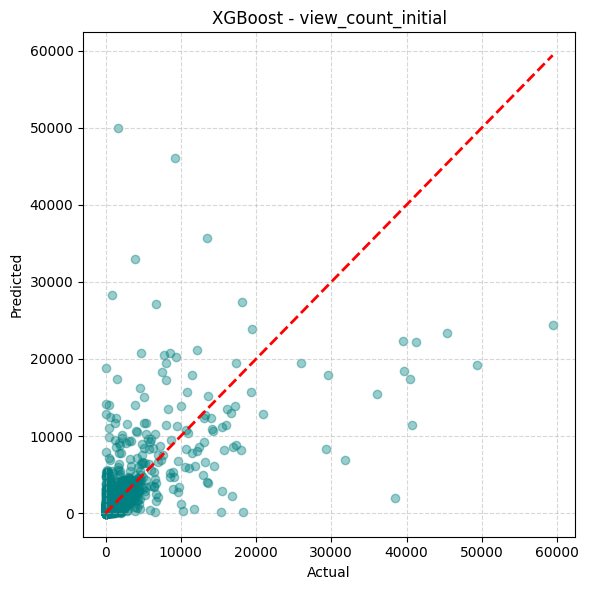

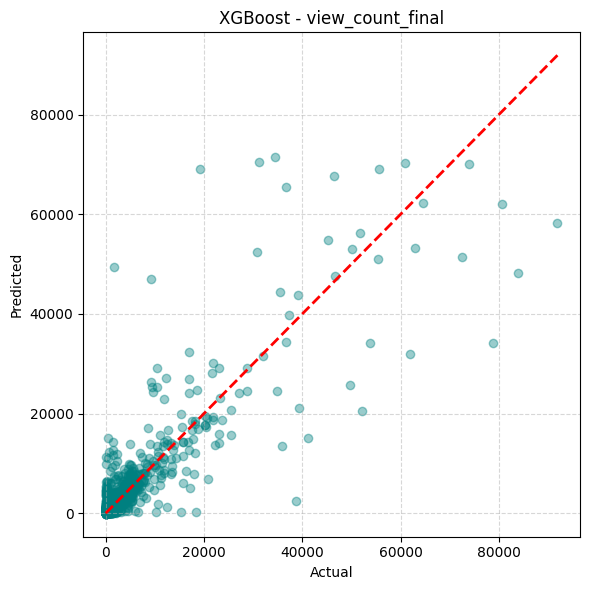

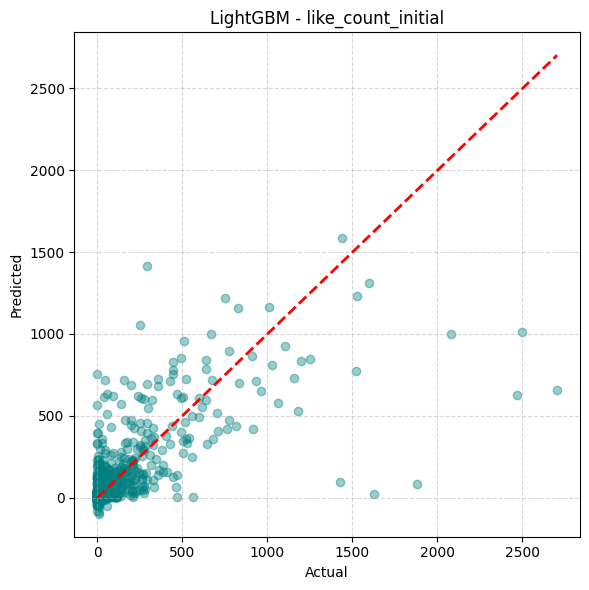

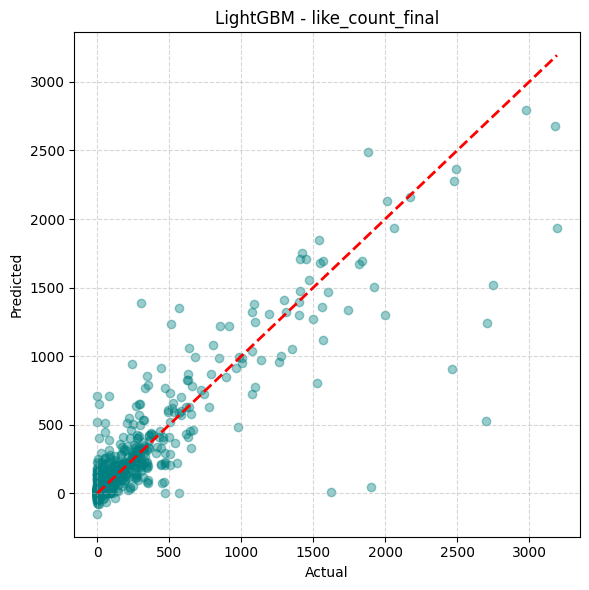

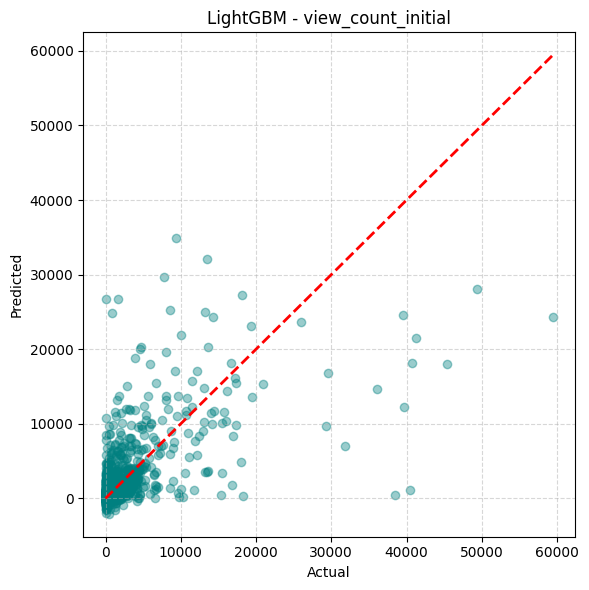

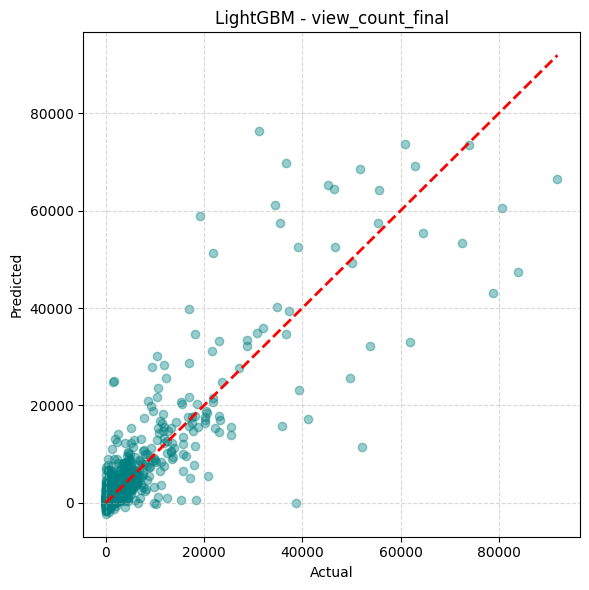

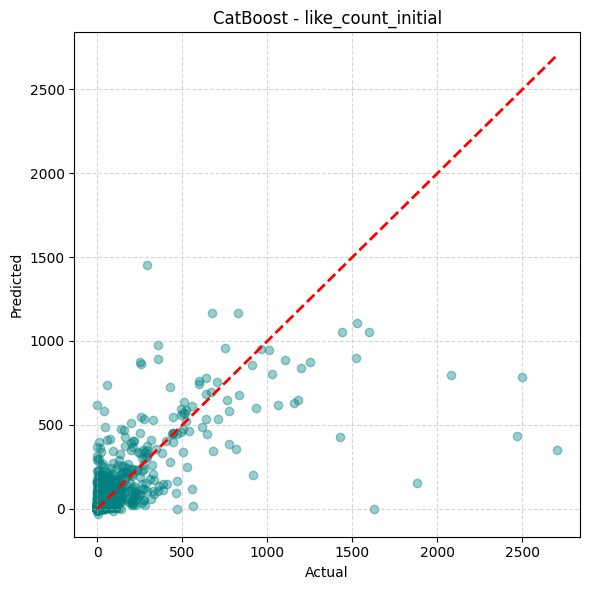

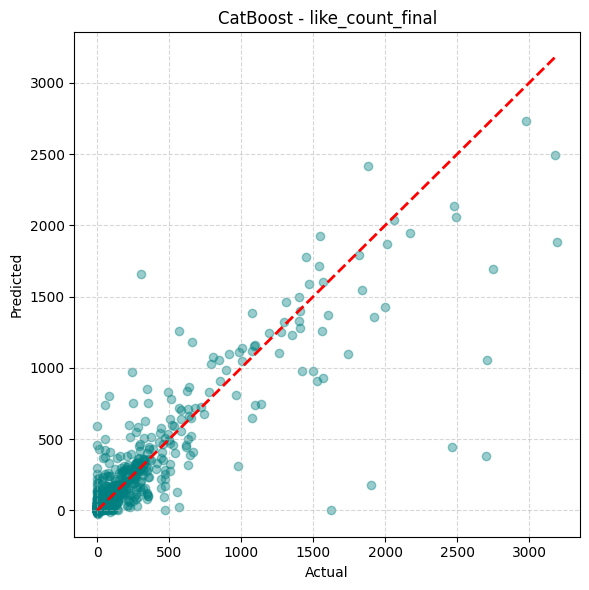

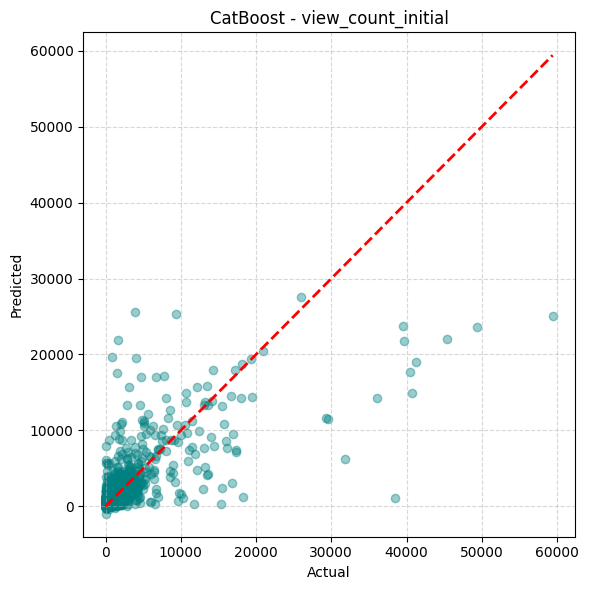

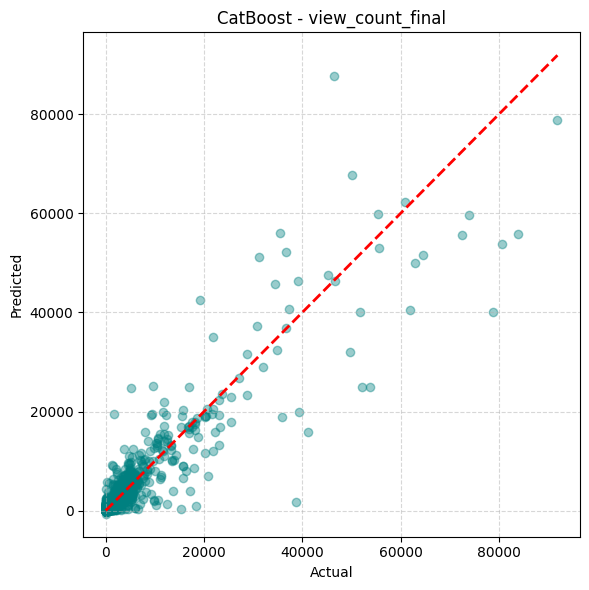

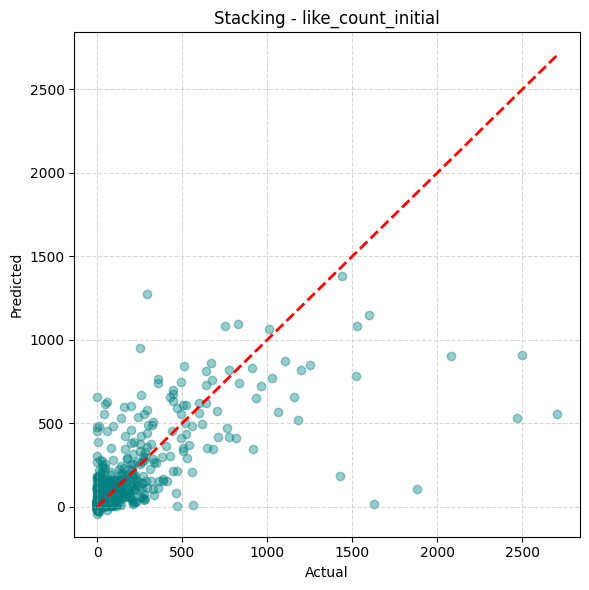

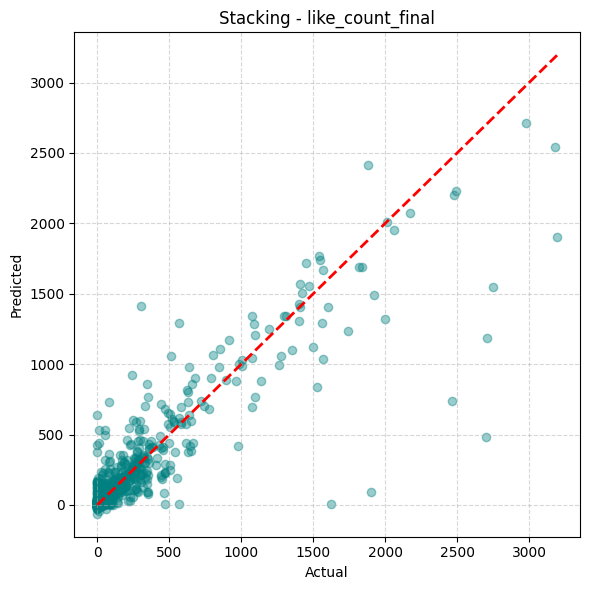

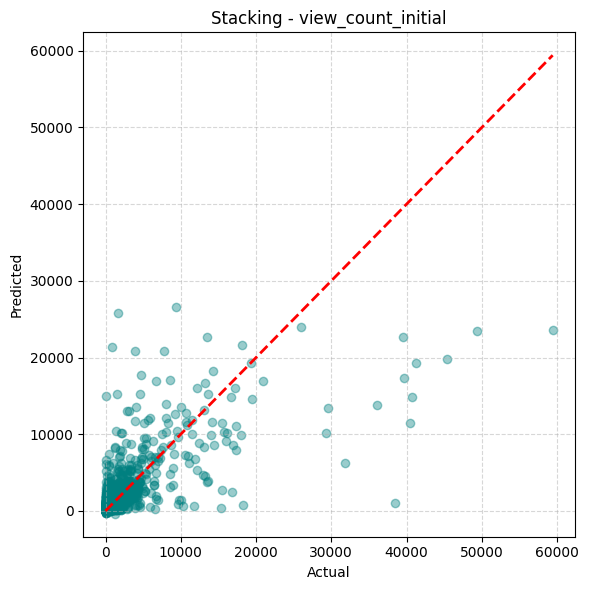

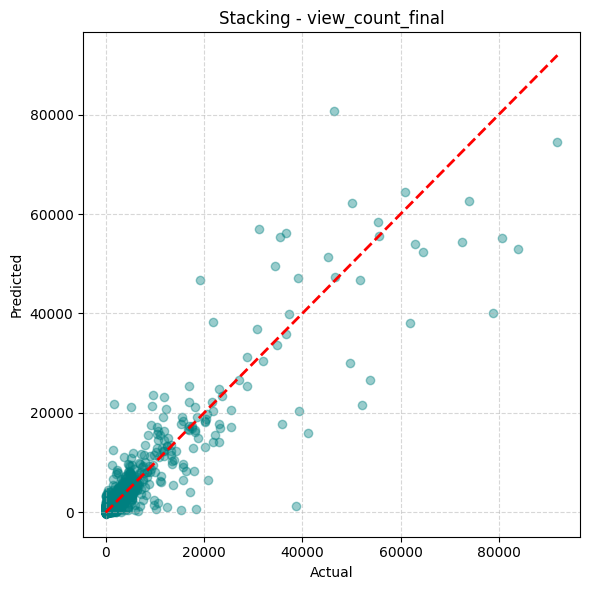

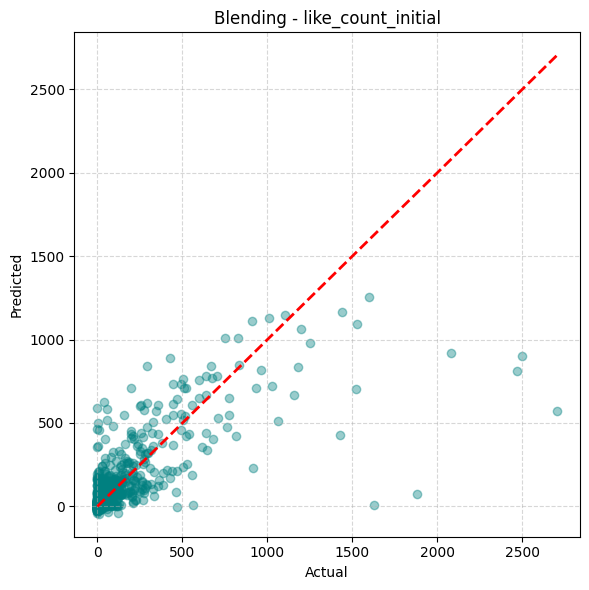

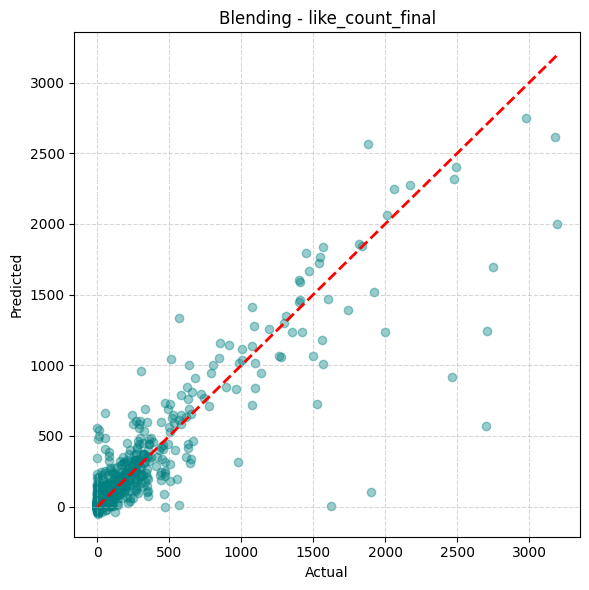

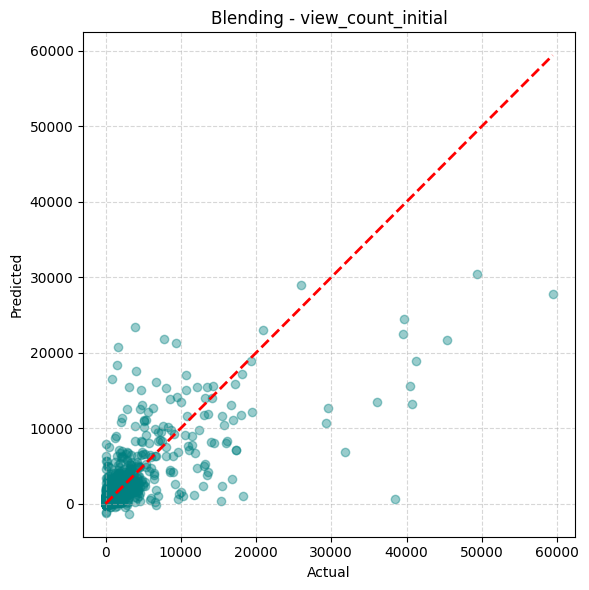

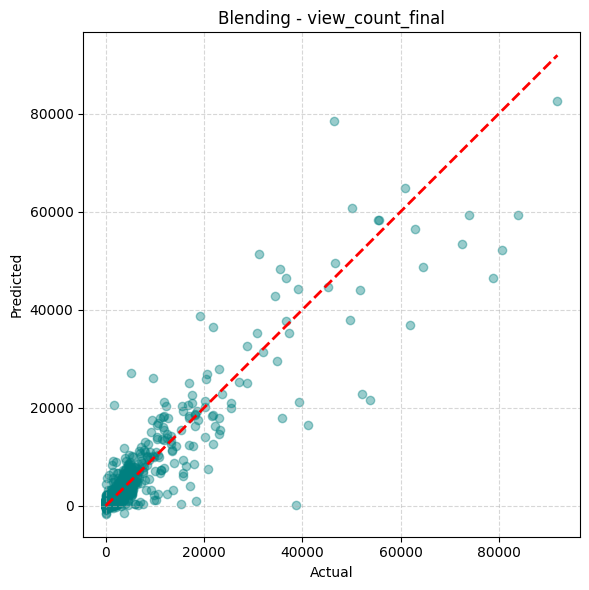

In [70]:
# Models and their predictions
model_preds = {
    "XGBoost": xgb_model2.predict(X_valid),
    "LightGBM": lgbm_model2.predict(X_valid),
    "CatBoost": catboost_model2.predict(X_valid),
    "Stacking": stacking_model2.predict(X_valid),
    "Blending": final_preds  # from your blending step
}

n_targets = y.shape[1]
target_names = y.columns.tolist()

# Plot
for model_name, preds in model_preds.items():
    for i in range(n_targets):
        plt.figure(figsize=(6, 6))
        plt.scatter(y_valid.iloc[:, i], preds[:, i], alpha=0.4, color='teal')
        plt.plot([y_valid.iloc[:, i].min(), y_valid.iloc[:, i].max()],
                 [y_valid.iloc[:, i].min(), y_valid.iloc[:, i].max()],
                 'r--', lw=2)  # y = x line

        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"{model_name} - {target_names[i]}")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

        # Save figure
        filename = f"../images/{model_name}_{target_names[i]}.png".replace(" ", "_")
        plt.savefig(filename)
        plt.close()  # Close the figure to save memory

In [71]:
# 1. Create a blend split from training data
X_base, X_blend, y_base, y_blend = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2. Wrap models in MultiOutputRegressor
xgb_model_blend = MultiOutputRegressor(xgb_model)
lgbm_model_blend = MultiOutputRegressor(lgbm_model)
catboost_model_blend = MultiOutputRegressor(catboost_model)

# 3. Train base models on base set
xgb_model_blend.fit(X_base, y_base)
lgbm_model_blend.fit(X_base, y_base)
catboost_model_blend.fit(X_base, y_base)

# 4. Predict on blend set to create meta features
xgb_preds_blend = xgb_model_blend.predict(X_blend)
lgbm_preds_blend = lgbm_model_blend.predict(X_blend)
catboost_preds_blend = catboost_model_blend.predict(X_blend)

# 5. Stack base model predictions horizontally for meta input
X_meta_blend = np.hstack([xgb_preds_blend, lgbm_preds_blend, catboost_preds_blend])

# 6. Train meta-model on blend predictions using Lasso
meta_model_blend = MultiOutputRegressor(Lasso(alpha=0.1, random_state=42))
meta_model_blend.fit(X_meta_blend, y_blend)

# 7. Predict on validation set using base models
xgb_preds_valid = xgb_model_blend.predict(X_valid)
lgbm_preds_valid = lgbm_model_blend.predict(X_valid)
catboost_preds_valid = catboost_model_blend.predict(X_valid)

# 8. Stack base predictions for final meta input
X_meta_valid = np.hstack([xgb_preds_valid, lgbm_preds_valid, catboost_preds_valid])

# 9. Final prediction from meta-model
final_preds = meta_model_blend.predict(X_meta_valid)

# 10. Evaluate
overall_mae = mean_absolute_error(y_valid, final_preds)
print("🧮 Blending with Lasso - Overall MAE:", overall_mae)

print("\nMAE for each output column:")
for col_idx in range(y_valid.shape[1]):
    col_mae = mean_absolute_error(y_valid.iloc[:, col_idx], final_preds[:, col_idx])
    print(f"Column {col_idx}: {col_mae:.4f}")


0:	learn: 146.9778915	total: 1.41ms	remaining: 2.57s
1:	learn: 146.2945288	total: 2.27ms	remaining: 2.06s
2:	learn: 145.6282716	total: 3.1ms	remaining: 1.87s
3:	learn: 144.9644136	total: 3.96ms	remaining: 1.79s
4:	learn: 144.3102594	total: 5.07ms	remaining: 1.84s
5:	learn: 143.6659232	total: 6.04ms	remaining: 1.82s
6:	learn: 143.0610635	total: 6.9ms	remaining: 1.78s
7:	learn: 142.4473023	total: 7.67ms	remaining: 1.73s
8:	learn: 141.8195197	total: 8.45ms	remaining: 1.7s
9:	learn: 141.2183728	total: 9.39ms	remaining: 1.7s
10:	learn: 140.6320634	total: 10.4ms	remaining: 1.7s
11:	learn: 140.0472900	total: 11.3ms	remaining: 1.7s
12:	learn: 139.4821887	total: 12.2ms	remaining: 1.69s
13:	learn: 138.9280429	total: 13.1ms	remaining: 1.68s
14:	learn: 138.3738195	total: 14ms	remaining: 1.68s
15:	learn: 137.8303391	total: 14.9ms	remaining: 1.68s
16:	learn: 137.2957119	total: 15.7ms	remaining: 1.67s
17:	learn: 136.7694660	total: 16.7ms	remaining: 1.67s
18:	learn: 136.2561922	total: 17.5ms	remaining

In [72]:
with open('../models/blending_with_lasso_model.pkl', 'wb') as f:
    pickle.dump(meta_model_blend, f)

with open('../models/xgb_blend_model.pkl', 'wb') as f:
    pickle.dump(xgb_model_blend, f)

with open('../models/lgbm_blend_model.pkl', 'wb') as f:
    pickle.dump(lgbm_model_blend, f)

with open('../models/catboost_blend_model.pkl', 'wb') as f:
    pickle.dump(catboost_preds_blend, f)

print('All models exported')